In [4]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score
from sklearn.model_selection import (
    cross_val_score, 
    KFold,
    GridSearchCV,
    StratifiedKFold,
    train_test_split, 
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from patsy.highlevel import dmatrices
import pprint as pp
import seaborn as sns
import matplotlib as plt

import sys
sys.path.append('..')
from src.data import load_data, load_excel, TRUE_VALUES, FALSE_VALUES
from src.metric import confusion_matrix,classificationSummary

pd.set_option('precision',4)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Advanced Techniques
Python's power derives from it's collection of libraries and utilities which give complete control over the entire process of data mining.  In this notebook we'll explore a few.

# Using the patsy library
Developing interaction factors is a pretty common feature of many data science platforms and this can of course be done with Python as well.  The issue is that this requires a lot of `for` loops or recursive functions to develop all the interactions with the various variables. 

(from the [patsy documentation](https://patsy.readthedocs.io/en/latest/overview.html))
>`patsy` is a Python package for describing statistical models (especially linear models, or models that have a linear component) and building design matrices. It is closely inspired by and compatible with the formula mini-language used in R and S.
>
>For instance, if we have some variable y, and we want to regress it against some other variables x, a, b, and the interaction of a and b, then we simply write:
>
>```patsy.dmatrices("y ~ x + a + b + a:b", data)```
>
> and Patsy takes care of building appropriate matrices. Furthermore, it:
> 
> * Allows data transformations to be specified using arbitrary Python code: instead of `x`, we could have written `log(x)`, `(x > 0)`, or even `log(x) if x > 1e-5 else log(1e-5)`,
> * Provides a range of convenient options for coding categorical variables, including automatic detection and removal > of redundancies,
> * Knows how to apply ‘the same’ transformation used on original data to new data, even for tricky transformations like > centering or standardization (critical if you want to use your model to make predictions),
> * Has an incremental mode to handle data sets which are too large to fit into memory at one time,
> * Provides a language for symbolic, human-readable specification of linear constraint matrices,
> * Has a thorough test suite (>97% statement coverage) and solid underlying theory, allowing it to correctly handle > corner cases that even R gets wrong, and
> * Features a simple API for integration into statistical packages.
> 
> What Patsy won’t do is, well, statistics — it just lets you describe models in general terms. It doesn’t know or 
> care whether you ultimately want to do linear regression, time-series analysis, or fit a forest of decision trees,
>  and it certainly won’t do any of those things for you — it just gives a high-level language for describing which 
> factors you want your underlying model to take into account. It’s not suitable for implementing arbitrary non-linear 
> models from scratch; for that, you’ll be better off with something like Theano, SymPy, or just plain Python. 
> But if you’re using a statistical package that requires you to provide a raw model matrix, then you can use Patsy to painlessly construct that model matrix; 

In [3]:
# Import and clean-up the heart disease dataset
heart_df = load_excel('HeartDisease_Cleveland',
                    dtype={'FBS': bool, 'EXANG': bool}, true_values=TRUE_VALUES,
                    false_values=FALSE_VALUES, na_values=['?'])
heart_df.dropna(inplace=True)
heart_df['DIAG'] = (heart_df.NUM > 0)
heart_df.drop(columns=['NUM'], inplace=True)
# Set the MAX_NEIGHBORS
MAX_NEIGHBORS = 25

In [4]:
# This function will build the matrices (that is the predictors with interactions)
def setup_matricies(df):

    # We'll look for DIAG as the target and 
    # Define SEX, CP, FBS, RESTECG, EXANG, SLOPE and THAL as categorical variables
    # The other predictors are already seen as numeric
    y, X = dmatrices('DIAG ~ AGE + C(SEX) + C(CP) + C(FBS) + TRESTBPS + CHOL +'
                         'C(RESTECG) + THALACH + C(EXANG) + OLDPEAK + C(SLOPE) +'
                         'CA + C(THAL) - 1', df, return_type='dataframe')

    # The y (target) matrix uses dummy encoding for both True and False values, 
    #  since we only need to know if TRUE or not we can drop it
    y.drop(columns=['DIAG[False]'],inplace=True)
    y.rename(columns={'DIAG[True':'DIAG'}, inplace=True)

    # For convenience we'll rename all the other columns so that we can read them
    X.rename(columns={'C(SEX)[T.1]':'Male','C(CP)[T.2]':'CP_Atypical',
                      'C(CP)[T.3]':'CP_NonAngina', 'C(CP)[T.4]':'CP_Asymptomatic',
                      'C(FBS)[T.True]':'FBS_True', 'C(RESTECG)[T.1]':'RESTECG_1',
                      'C(RESTECG)[T.2]':'RESTECG_2', 'C(EXANG)[T.1]':'EXANG_True',
                      'C(SLOPE)[T.2]':'SLOPE_Flat', 'C(SLOPE)[T.3]':'SLOPE_Down',
                      'C(THAL)[T.6.0]':'THAL_FIXED', 'C(THAL)[T.7.0]':'THAL_REV'},
            inplace=True)

    print(f'X_shape:{X.shape}, y_shape:{y.shape}')
    y = np.ravel(y)
    return X, y

# It's convenient to have the preceding in a function so that we can call it again later if needed
X, y = setup_matricies(heart_df)

X_shape:(297, 19), y_shape:(297, 1)


In [5]:
# by setting the random_state variable, we can ensure that each time we run the method 
# we get the same splits
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.40, random_state=123)

In [6]:
# Now let's see if we can find a good model just by varying the values of K
best_score = 0
best_k = 0
clf = None
for K in range(1, MAX_NEIGHBORS, 2):
    # We are only going to change the number of neighbors on each pass to see if it helps
    clf = KNeighborsClassifier(n_neighbors=K, weights='uniform', algorithm='auto', n_jobs=-1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    score = accuracy_score(y_valid, y_pred)
    if score > best_score:
        best_score = score
        best_k = K
        best_y_pred = y_pred
print(f'Best for K (simple) = {best_k} Score: {best_score:.6f}')

Best for K (simple) = 7 Score: 0.663866


# Cross-Validation
Another technique that helps us to ensure that we are not overfitting our model (that is we haven't learned so well on known data that it doesn't perform as well on unseen data.)  Typically we would split our dataset into training and validation (or test) sets.  This method uses a portion of our data to train the model and another hold-out portion to see how well the model fits some unseen data.  This can be helpful, but it still can lead to overfitting as we try to get a good model that performs well on the hold-out data.  One way to combat this approach is to use cross-validation.  While there are a number of approaches to cross-validation, the idea is the same:
    
1. Partition the data into a number of subsets
2. Hold out 1 set at a time as our test set
3. Train the model on the other sets
4. Repeat the process for each subset

We can cross-validate in a number of ways:
* Leave one out cross validation
* k-fold cross validation
* Stratified k-fold cross validation
* Time Series cross validation

## k-Fold Cross Validation
<style>
.center
{
    display:block;
    margin-left: auto;
    margin-right: auto;
    width: 50%;
}
</style>
Let's start with k-Fold Cross Validation

The procedure has a single parameter called k that refers to the number of groups that a given data sample is to be split into. As such, the procedure is often called k-fold cross-validation. When a specific value for k is chosen, it may be used in place of k in the reference to the model, such as k=10 becoming 10-fold cross-validation.
If k=5 the dataset will be divided into 5 equal parts and the below process will run 5 times, each time with a different holdout set.
1. Take the group as a holdout or test data set
2. Take the remaining groups as a training data set
3. Fit a model on the training set and evaluate it on the test set
4. Retain the evaluation score and discard the model

<img src='../img/k-fold-cv.png' width=400 height=400 class='center'/>


In [7]:
# Here well do a simple k-Fold cross validation
NUMBER_OF_SPLITS = 5
best_c_val = 0
best_k = 0
best_model = None
for n in range(1, MAX_NEIGHBORS, 2):
    clf = KNeighborsClassifier(n_neighbors=n)
    c_val = cross_val_score(clf, X, y, cv=NUMBER_OF_SPLITS, scoring='accuracy').mean()
    if c_val > best_c_val:
        best_c_val = c_val
        best_k = n
        best_model = clf
print(f'Best for K (cross_val) = {best_k} Score: {best_c_val:.6f}')


Best for K (cross_val) = 13 Score: 0.660113


## Stratified k-Fold Cross Validation
This is the same concept as [k-Fold](#k-fold-cross-validation) but slightly different.  In this approach, rather than using a fixed size of for each set, the sets are broken up based on either a categorical predictor or categorical target (most often).  The idea is to ensure that each set has exactly the same proportion of the selected field in each set.
<style>
.center
{
    display:block;
    margin-left: auto;
    margin-right: auto;
    width: 50%;
}
</style>
<img src='../img/k-fold-strat.png' width=400 height=400 class='center'/>

In [8]:
heart_df.head()

,AGE,SEX,CP,TRESTBPS,CHOL,FBS,RESTECG,THALACH,EXANG,OLDPEAK,SLOPE,CA,THAL,DIAG
0,63,1,1,145,233,True,2,150,False,2.3,3,0.0,6.0,False
1,67,1,4,160,286,False,2,108,True,1.5,2,3.0,3.0,True
2,67,1,4,120,229,False,2,129,True,2.6,2,2.0,7.0,True
3,37,1,3,130,250,False,0,187,False,3.5,3,0.0,3.0,False
4,41,0,2,130,204,False,2,172,False,1.4,1,0.0,3.0,False


False    0.5387
True     0.4613
Name: DIAG, dtype: float64

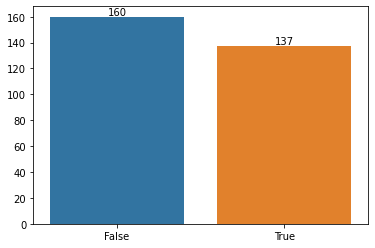

In [9]:
# Start by looking at the breakdown of our classes
ax = sns.barplot(x=['False','True'],y=np.array(heart_df.DIAG.value_counts()),)
ax.bar_label(ax.containers[0])

heart_df.DIAG.value_counts()/len(heart_df)

In [10]:
# Here we'll do a stratified k-Fold cross validation
# Keep in mind this procedure works best when their are unbalanced classes in the target


NUMBER_OF_SPLITS = 5
best_c_val = 0
best_k = 0
best_model = None
# The 
skf = StratifiedKFold(n_splits=NUMBER_OF_SPLITS)
for train, test in skf.split(X,y):
    for n in range(1, MAX_NEIGHBORS, 2):
        clf = KNeighborsClassifier(n_neighbors=n)
        c_val = cross_val_score(clf, X, y, cv=skf, scoring='accuracy').mean()
        if c_val > best_c_val:
            best_c_val = c_val
            best_k = n
            best_model = clf
print(f'Best for K (stratified cross_val) = {best_k} Score: {best_c_val:.6f}')

Best for K (stratified cross_val) = 13 Score: 0.660113


# Pipelines
Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

__Convenience and encapsulation__
    <br/>You only have to call fit and predict once on your data to fit a whole sequence of estimators.

__Joint parameter selection__
    <br/>You can grid search over parameters of all estimators in the pipeline at once.

__Safety__
    <br/>Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

All estimators in a pipeline, except the last one, must be transformers (i.e. must have a transform method). The last estimator may be any type (transformer, classifier, etc.).

*(source: [sklearn documentation](https://scikit-learn.org/stable/modules/compose.html#pipeline))*

We can use a pipeline for instance to standardize our data prior to running the Nearest Neighbors classifier.

In [11]:
clf = KNeighborsClassifier(n_neighbors=K, weights='uniform', algorithm='auto', n_jobs=-1)
pipe = Pipeline([('scaler', StandardScaler()),('classifier',clf)])
pipe.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 KNeighborsClassifier(n_jobs=-1, n_neighbors=23))])

In [12]:
# Now score our data
pipe.score(X_valid,y_valid)

0.7815126050420168

# Find the best combination of parameters - GridSearch <a id='grid-search'></a>

So far we have only dealt with a few parameters in our classifier and we used loops to try different values of `k` to determine the best number of neighbors for our model.  When we start to build up pipelines of estimators/classifiers/pre-processing which each have multiple parameters to tweak, if can be very difficult to keep track of combination of paramters that have been tried and which is the best.  The `sklearn` library has us covered.  In these cases we can use a [grid-search](https://scikit-learn.org/stable/modules/grid_search.html#grid-search).

A grid-search is used to tune the 'hyper-parameters' (that is parameters that are not learnt with estimators).  In other words they are the parameters to the constructor for each classification/estimator function.  A grid search is a cross-validation method whereby different combinations of all the parameters are attempted.  [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) will try all the combinations exhaustively, while [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV) can sample the set of parameter combinations.  Both of these tools have successive halving counterparts which can be a bit quicker at finding the right combination.

(Before blindly attempting to brute force try all the combinations of different parameters it is best to consult each estimator/transformer to see which parameters have the greatest impact.  sklearn provies a good [best practice](https://scikit-learn.org/stable/modules/grid_search.html#grid-search-tips)) guide which can help [avoid brute force parameter searches](https://scikit-learn.org/stable/modules/grid_search.html#alternative-cv))

In [14]:
# These are the parameters that will be used to try and come up with the best model
param_grid = [
    {
        # Try a range of options to figure out the optimal number of features
        # Accessing parameters of the pipeline by name takes the following form:
        #  pipeline_step_name + '__' + parameter name
        'classifier__n_neighbors': range(1,MAX_NEIGHBORS,2),
        'classifier__weights': ['uniform', 'distance'],
        'feature_selection' : [SelectKBest(f_classif)],
        'PCA__whiten':[True, False],
        'PCA__svd_solver':['auto', 'full', 'arpack', 'randomized'],
    }
]
clf_pipe = Pipeline([('feature_selection', SelectKBest(f_classif)),
                        ('PCA', PCA()),
                    ('classifier', KNeighborsClassifier(n_jobs=-1))])

# Go through an exhaustive search by combining all the variables specified in the
clf = GridSearchCV(clf_pipe, cv=10, param_grid=param_grid, n_jobs=-1)
# Again no need to have holdout data because the algorithm will hold out data for each k-fold pass
clf.fit(X, y)
# Now that we have fit the model, we'll take the best_estimator according to the GridSearch
best_estimator = clf.best_estimator_.named_steps['classifier']
print(f'{best_estimator}')
print(f'Best parameters for Grid Search: ')
pp.pprint(clf.best_params_)
print(f'Best score for Grid Search = {clf.best_score_:.6f}')

KNeighborsClassifier(n_jobs=-1, n_neighbors=13)
Best parameters for Grid Search: 
{'PCA__svd_solver': 'arpack',
 'PCA__whiten': True,
 'classifier__n_neighbors': 13,
 'classifier__weights': 'uniform',
 'feature_selection': SelectKBest()}
Best score for Grid Search = 0.845172


# Ensembling
Ensembling refers to learning in which multiple models are used to produce a single outcome.  Often these models are considered "weak learners" because they intentionally try to underfit so that the final model is not overfit when the models are combined.

There are generally two different types of ensembling:
*   __Averaging__ - in these approaches multiple models are created and the outcomes are aggregated into a final result.  The aggregation made be via voting or by averaging the responses.
    *  _Examples include_: Bagging methods, and Randomized Trees
*   __Boosting__ - alternatively boosting methods take weaker models and run them in series.  This means that the output of each model provides a factor for subsequent models to use in the learning task.  
    *  _Examples include_: AdaBoost, Gradient Tree Boosting

In [18]:
# German Credit
# Assume all columns are categorical
credit_df = load_data('GermanCredit', index_col="OBS#",dtype='category')
credit_df.rename(columns={"RADIO/TV":"RADIO_TV","CO-APPLICANT":"CO-APPLICANT"}, inplace=True)
credit_df = credit_df.astype({'DURATION':float,'AMOUNT':float, 'INSTALL_RATE':float, 'AGE':float,'NUM_CREDITS':float,'NUM_DEPENDENTS':float})
credit_df.head()


,CHK_ACCT,DURATION,HISTORY,NEW_CAR,USED_CAR,FURNITURE,RADIO_TV,EDUCATION,RETRAINING,AMOUNT,SAV_ACCT,EMPLOYMENT,INSTALL_RATE,MALE_DIV,MALE_SINGLE,MALE_MAR_or_WID,CO-APPLICANT,GUARANTOR,PRESENT_RESIDENT,REAL_ESTATE,PROP_UNKN_NONE,AGE,OTHER_INSTALL,RENT,OWN_RES,NUM_CREDITS,JOB,NUM_DEPENDENTS,TELEPHONE,FOREIGN,RESPONSE
OBS#,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,6.0,4,0,0,0,1,0,0,1169.0,4,4,4.0,0,1,0,0,0,4,1,0,67.0,0,0,1,2.0,2,1.0,1,0,1
2,1,48.0,2,0,0,0,1,0,0,5951.0,0,2,2.0,0,0,0,0,0,2,1,0,22.0,0,0,1,1.0,2,1.0,0,0,0
3,3,12.0,4,0,0,0,0,1,0,2096.0,0,3,2.0,0,1,0,0,0,3,1,0,49.0,0,0,1,1.0,1,2.0,0,0,1
4,0,42.0,2,0,0,1,0,0,0,7882.0,0,3,2.0,0,1,0,0,1,4,0,0,45.0,0,0,0,1.0,2,2.0,0,0,1
5,0,24.0,3,1,0,0,0,0,0,4870.0,0,2,3.0,0,1,0,0,0,4,0,1,53.0,0,0,0,2.0,2,2.0,0,0,0


Good for us we have a couple of ways to use Ensembling to make this work.  We can use the built in essemble methods like 

<div align='center'/>

[Back to TOC](./00-Introduction.ipynb)